In [2]:
%matplotlib inline
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set()

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.optim import Optimizer


import collections
import h5py, sys
import gzip
import os
import math

import time
import torch.utils.data
from torchvision import transforms, datasets
import scipy.ndimage as ndim

try:
    import cPickle as pickle
except:
    import pickle

In [3]:
def errorfill(x, y, yerr, color=None, alpha_fill=0.3, ax=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    plt_return = ax.plot(x, y, color=color)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill)
    
    return plt_return

In [4]:
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  
s_rot = 0
end_rot = 179
steps = 16
rotations = (np.linspace(s_rot, end_rot, steps)).astype(int)

# Entropy for rotating digits plots

### Regular NN

This is aleatoric?

(10000, 1, 28, 28)
(10000,)


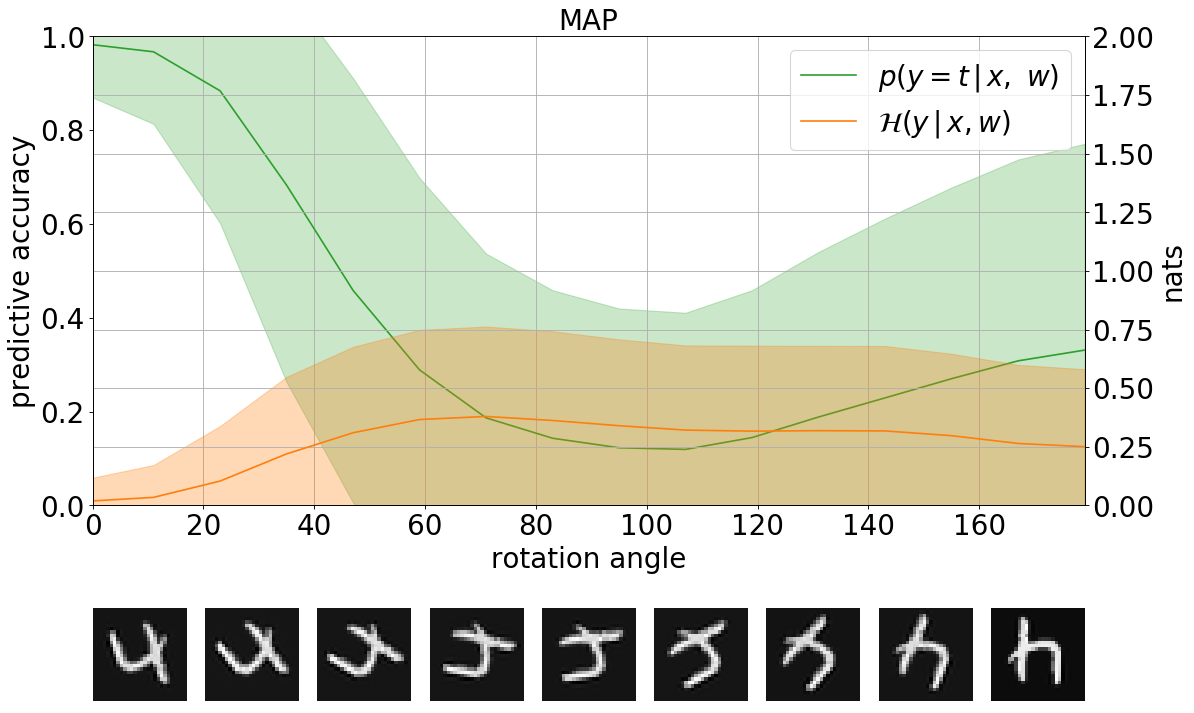

In [35]:
s_rot = 0
end_rot = 179
steps = 16
rotations = (np.linspace(s_rot, end_rot, steps)).astype(int)

batch_size = 128
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])
valset = datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=3)

x_dev = []
y_dev = []
for x, y in valloader:
    x_dev.append(x.cpu().numpy())
    y_dev.append(y.cpu().numpy())

x_dev = np.concatenate(x_dev)
y_dev = np.concatenate(y_dev)
print(x_dev.shape)
print(y_dev.shape)

result_name_list = ['results_regular_NN_MNIST']

correct_preds = np.load(result_name_list[0] + '/correct_preds.npy')
all_preds = np.load(result_name_list[0] + '/all_preds.npy')

#
pred_entropy = -(all_preds * np.log(all_preds)).sum(axis=2)
pred_entropy_mean = pred_entropy.mean(axis=0)
pred_entropy_std = pred_entropy.std(axis=0)


# Get correct prediction probabilities
correct_mean = correct_preds.mean(axis=0)
correct_std = correct_preds.std(axis=0)


fs = 25

# plt.figure(dpi=100)
# ax = plt.gca()
fig = plt.figure(figsize=(steps, 12), dpi=80)

ax = plt.subplot2grid((3, steps-1), (0, 0), rowspan=2, colspan=steps-1)


ax2 = ax.twinx()

aa, = errorfill(rotations, correct_mean, yerr=correct_std, color=c[2], alpha_fill=0.25, ax=ax)

#     ax = plt.gca()
ax.set_xlabel('rotation angle')
ax.set_ylabel('predictive accuracy')
ax.set_title('MAP')
ax2.yaxis.grid()
ax.xaxis.grid() 



ax2.set_ylabel('nats')
# bb, = errorfill(rotations, total_entropy_mean, yerr=total_entropy_std, color=c[0], ax=ax2)
cc, = errorfill(rotations, pred_entropy_mean, yerr=pred_entropy_std, color=c[1], ax=ax2)
#     dd, = errorfill(rotations, epistemic_entropy_mean, yerr=epistemic_entropy_std, color=c[3], ax=ax2)


# lgd = plt.legend(['correct class', 'posterior predictive entropy'], loc='upper right',
#                  prop={'size': 15, 'weight': 'normal'}, bbox_to_anchor=(1.4,1))

p_lgd = [aa, cc]
lgd = plt.legend(p_lgd,
['$p(y = t\,|\, x, \ w)$', '$\mathcal{H}(y\,|\, x, w)$'],
                prop={'size': 25, 'weight': 'normal'})


plt.autoscale(enable=True, axis='x', tight=True)

Nim = 49
s_rot = 0
end_rot = 179
steps = 10
rotations = (np.linspace(s_rot, end_rot, steps)).astype(int)

for i in range(1,len(rotations)):
    angle = rotations[i]
    x_rot = np.expand_dims(ndim.interpolation.rotate(x_dev[Nim, 0, :, :], angle, reshape=False, cval=-0.42421296), 0)
    ax3 = fig.add_subplot(3, (steps-1), 2*(steps-1)+i)
    ax3.imshow(x_rot[0,:,:], cmap='gray')
    ax3.axis('off')
    ax3.set_xticklabels([])
    ax3.set_yticklabels([])

    
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + [ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
            ax.get_xticklabels() + ax.get_yticklabels() + ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(fs)
    item.set_weight('normal')

plt.autoscale(enable=True, axis='x', tight=True)
ax.set_ylim(bottom=0, top=1)
ax2.set_ylim(bottom=0, top=2)



plt.show()

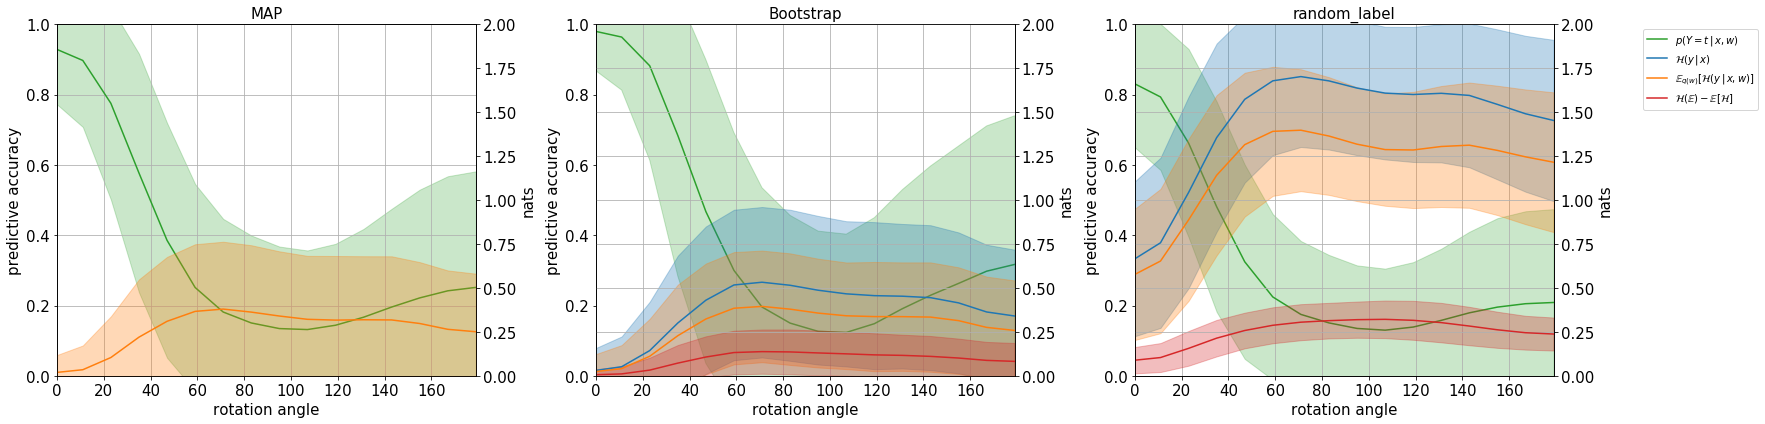

In [31]:
result_name_list = ['results_bootstrap_ensemble_NN_MNIST', 'results_random_label_local_reparam_MNIST']
names = ['Bootstrap', 'random_label']

# plt.figure(dpi=120)


fs = 15
Ncols = len(result_name_list)

f, ax_vec = plt.subplots(1, Ncols, figsize=(7*(Ncols+0.5), 6)) # , sharey=True

for idx, dirname in enumerate(result_name_list):
    
    ax = ax_vec[idx+1]
    ax2 = ax.twinx()

    correct_preds = np.load(dirname + '/correct_preds.npy')
    all_preds = np.load(dirname + '/all_preds.npy')
    all_sample_preds = np.load(dirname + '/all_sample_preds.npy')
    all_sample_preds = all_sample_preds + 1e-5


    # print(correct_preds.shape)
    # print(all_sample_preds.shape)

    # Get correct prediction probabilities
    correct_mean = correct_preds.mean(axis=0)
    correct_std = correct_preds.std(axis=0)

    # Compute the approx posterior predictive
    posterior_preds = all_sample_preds.mean(axis=1)
    total_entropy = -(posterior_preds * np.log(posterior_preds)).sum(axis=2)
    total_entropy_mean = total_entropy.mean(axis=0)
    total_entropy_std = total_entropy.std(axis=0)

    # Get sample wise metrics (entropy) -> aleatoric entropy
    sample_preds_entropy = -( all_sample_preds * np.log(all_sample_preds) ).sum(axis=3)
    aleatoric_entropy = sample_preds_entropy.mean(axis=1)
    aleatoric_entropy_mean = aleatoric_entropy.mean(axis=0)
    aleatoric_entropy_std = aleatoric_entropy.std(axis=0)

    # Get epistemic entropy 
    epistemic_entropy = total_entropy - aleatoric_entropy
    epistemic_entropy_mean = epistemic_entropy.mean(axis=0)
    epistemic_entropy_std = epistemic_entropy.std(axis=0)

    # print('expected entropy mean', aleatoric_entropy_mean.shape)
    # print('posterior entropy mean', posterior_mean_angle_entropy.shape)


    aa, = errorfill(rotations, correct_mean, yerr=correct_std, color=c[2], alpha_fill=0.25, ax=ax)

#     ax = plt.gca()
    ax.set_xlabel('rotation angle')
    ax.set_ylabel('predictive accuracy')
    ax.set_title('%s' % names[idx])
    
    ax2.yaxis.grid() 
    ax.xaxis.grid() 

    
    ax2.set_ylabel('nats')
    bb, = errorfill(rotations, total_entropy_mean, yerr=total_entropy_std, color=c[0], ax=ax2)
    cc, = errorfill(rotations, aleatoric_entropy_mean, yerr=aleatoric_entropy_std, color=c[1], ax=ax2)
    dd, = errorfill(rotations, epistemic_entropy_mean, yerr=epistemic_entropy_std, color=c[3], ax=ax2)


    # lgd = plt.legend(['correct class', 'posterior predictive entropy'], loc='upper right',
    #                  prop={'size': 15, 'weight': 'normal'}, bbox_to_anchor=(1.4,1))


    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + [ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels() + ax2.get_xticklabels() + ax2.get_yticklabels()):
        item.set_fontsize(fs)
        item.set_weight('normal')

    plt.autoscale(enable=True, axis='x', tight=True)
    ax.set_ylim(bottom=0, top=1)
    ax2.set_ylim(bottom=0, top=2)

    
p_lgd = [aa, bb, cc, dd]
lgd = plt.legend(p_lgd, ['$p(Y = t\,|\,x, w)$', '$\mathcal{H}(y\,|\,x)$', '$\mathbb{E}_{q(w)}[\mathcal{H}(y\,|\,x, w)]$', '$\mathcal{H}(\mathbb{E}) - \mathbb{E}[\mathcal{H}]$'],
                 bbox_to_anchor=(1.5, 1))

plt.tight_layout()

In [18]:
s_rot = 0
end_rot = 179
steps = 16
rotations = (np.linspace(s_rot, end_rot, steps)).astype(int)

Get correct pred stats and also entropies -> cant get them because dont have sampling predictions -> getting now

* BBB_MC_Gaussian #RUNNING


In [19]:
result_name_list

['results_bootstrap_ensemble_NN_MNIST',
 'results_random_label_local_reparam_MNIST']

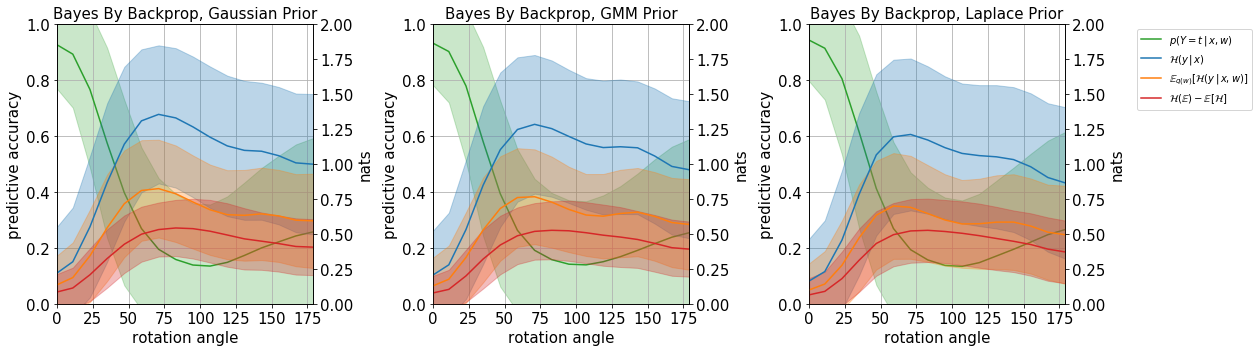

In [20]:
result_name_list = ['results_weight_uncertainty_MC_MNIST_gaussian', 'results_weight_uncertainty_MC_MNIST_GMM', 'results_weight_uncertainty_MC_MNIST_laplace']
names = ['Gaussian', 'GMM', 'Laplace']

# plt.figure(dpi=120)

fs = 15
Ncols = len(result_name_list)

f, ax_vec = plt.subplots(1, Ncols, figsize=(6*Ncols, 5)) # , sharey=True


for idx, dirname in enumerate(result_name_list):
    
    ax = ax_vec[idx]
    ax2 = ax.twinx()

    correct_preds = np.load(dirname + '/correct_preds.npy')
    all_preds = np.load(dirname + '/all_preds.npy')
    all_sample_preds = np.load(dirname + '/all_sample_preds.npy')
    all_sample_preds = all_sample_preds + 1e-5


    # print(correct_preds.shape)
    # print(all_sample_preds.shape)

    # Get correct prediction probabilities
    correct_mean = correct_preds.mean(axis=0)
    correct_std = correct_preds.std(axis=0)

    # Compute the approx posterior predictive
    posterior_preds = all_sample_preds.mean(axis=1)
    total_entropy = -(posterior_preds * np.log(posterior_preds)).sum(axis=2)
    total_entropy_mean = total_entropy.mean(axis=0)
    total_entropy_std = total_entropy.std(axis=0)

    # Get sample wise metrics (entropy) -> aleatoric entropy
    sample_preds_entropy = -( all_sample_preds * np.log(all_sample_preds) ).sum(axis=3)
    aleatoric_entropy = sample_preds_entropy.mean(axis=1)
    aleatoric_entropy_mean = aleatoric_entropy.mean(axis=0)
    aleatoric_entropy_std = aleatoric_entropy.std(axis=0)

    # Get epistemic entropy 
    epistemic_entropy = total_entropy - aleatoric_entropy
    epistemic_entropy_mean = epistemic_entropy.mean(axis=0)
    epistemic_entropy_std = epistemic_entropy.std(axis=0)

    # print('expected entropy mean', aleatoric_entropy_mean.shape)
    # print('posterior entropy mean', posterior_mean_angle_entropy.shape)


    aa, = errorfill(rotations, correct_mean, yerr=correct_std, color=c[2], alpha_fill=0.25, ax=ax)

#     ax = plt.gca()
    ax.set_xlabel('rotation angle')
    ax.set_ylabel('predictive accuracy')
    ax.set_title('Bayes By Backprop, %s Prior' % names[idx])
    ax.yaxis.grid()
    ax.xaxis.grid()

    
    ax2.set_ylabel('nats')
    bb, = errorfill(rotations, total_entropy_mean, yerr=total_entropy_std, color=c[0], ax=ax2)
    cc, = errorfill(rotations, aleatoric_entropy_mean, yerr=aleatoric_entropy_std, color=c[1], ax=ax2)
    dd, = errorfill(rotations, epistemic_entropy_mean, yerr=epistemic_entropy_std, color=c[3], ax=ax2)


    # lgd = plt.legend(['correct class', 'posterior predictive entropy'], loc='upper right',
    #                  prop={'size': 15, 'weight': 'normal'}, bbox_to_anchor=(1.4,1))


    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + [ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels() + ax2.get_xticklabels() + ax2.get_yticklabels()):
        item.set_fontsize(fs)
        item.set_weight('normal')

    plt.autoscale(enable=True, axis='x', tight=True)
    ax.set_ylim(bottom=0, top=1)
    ax2.set_ylim(bottom=0, top=2)

    
p_lgd = [aa, bb, cc, dd]
lgd = plt.legend(p_lgd, ['$p(Y = t\,|\,x, w)$', '$\mathcal{H}(y\,|\,x)$', '$\mathbb{E}_{q(w)}[\mathcal{H}(y\,|\,x, w)]$', '$\mathcal{H}(\mathbb{E}) - \mathbb{E}[\mathcal{H}]$'], bbox_to_anchor=(1.75,1))

plt.tight_layout()

## Compare with local reparametrisation

## MC dropout and SGLD, pSGLD

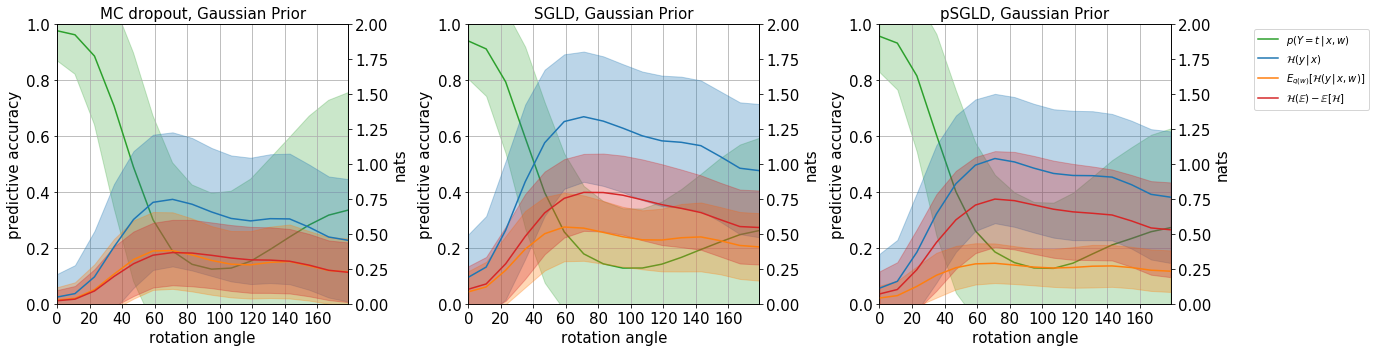

In [21]:
result_name_list = ['results_MC_dropout_MNIST', 'results_SGLD_MNIST', 'results_pSGLD_MNIST']
names = ['MC dropout', 'SGLD', 'pSGLD']

# plt.figure(dpi=120)

fs = 15
Ncols = len(result_name_list)

f, ax_vec = plt.subplots(1, Ncols, figsize=(6.5*Ncols, 5)) # , sharey=True


for idx, dirname in enumerate(result_name_list):
    
    ax = ax_vec[idx]
    ax2 = ax.twinx()

    correct_preds = np.load(dirname + '/correct_preds.npy')
    all_preds = np.load(dirname + '/all_preds.npy')
    all_sample_preds = np.load(dirname + '/all_sample_preds.npy')
    all_sample_preds = all_sample_preds + 1e-5

    # print(correct_preds.shape)
    # print(all_sample_preds.shape)

    # Get correct prediction probabilities
    correct_mean = correct_preds.mean(axis=0)
    correct_std = correct_preds.std(axis=0)

    # Compute the approx posterior predictive
    posterior_preds = all_sample_preds.mean(axis=1)
    total_entropy = -(posterior_preds * np.log(posterior_preds)).sum(axis=2)
    total_entropy_mean = total_entropy.mean(axis=0)
    total_entropy_std = total_entropy.std(axis=0)

    # Get sample wise metrics (entropy) -> aleatoric entropy
    sample_preds_entropy = -( all_sample_preds * np.log(all_sample_preds) ).sum(axis=3)
    aleatoric_entropy = sample_preds_entropy.mean(axis=1)
    aleatoric_entropy_mean = aleatoric_entropy.mean(axis=0)
    aleatoric_entropy_std = aleatoric_entropy.std(axis=0)

    # Get epistemic entropy 
    epistemic_entropy = total_entropy - aleatoric_entropy
    epistemic_entropy_mean = epistemic_entropy.mean(axis=0)
    epistemic_entropy_std = epistemic_entropy.std(axis=0)

    # print('expected entropy mean', aleatoric_entropy_mean.shape)
    # print('posterior entropy mean', posterior_mean_angle_entropy.shape)


    aa, = errorfill(rotations, correct_mean, yerr=correct_std, color=c[2], alpha_fill=0.25, ax=ax)

#     ax = plt.gca()
    ax.set_xlabel('rotation angle')
    ax.set_ylabel('predictive accuracy')
    ax.set_title('%s, Gaussian Prior' % names[idx])
    ax.yaxis.grid() 
    ax.xaxis.grid()

    
    ax2.set_ylabel('nats')
    bb, = errorfill(rotations, total_entropy_mean, yerr=total_entropy_std, color=c[0], ax=ax2)
    cc, = errorfill(rotations, aleatoric_entropy_mean, yerr=aleatoric_entropy_std, color=c[1], ax=ax2)
    dd, = errorfill(rotations, epistemic_entropy_mean, yerr=epistemic_entropy_std, color=c[3], ax=ax2)


    # lgd = plt.legend(['correct class', 'posterior predictive entropy'], loc='upper right',
    #                  prop={'size': 15, 'weight': 'normal'}, bbox_to_anchor=(1.4,1))


    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + [ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels() + ax2.get_xticklabels() + ax2.get_yticklabels()):
        item.set_fontsize(fs)
        item.set_weight('normal')

    plt.autoscale(enable=True, axis='x', tight=True)
    ax.set_ylim(bottom=0, top=1)
    ax2.set_ylim(bottom=0, top=2)

    
p_lgd = [aa, bb, cc, dd]
lgd = plt.legend(p_lgd, ['$p(Y = t\,|\,x, w)$', '$\mathcal{H}(y\,|\,x)$', '$E_{q(w)}[\mathcal{H}(y\,|\,x, w)]$', '$\mathcal{H}(\mathbb{E}) - \mathbb{E}[\mathcal{H}]$'], bbox_to_anchor=(1.7,1))

plt.tight_layout()

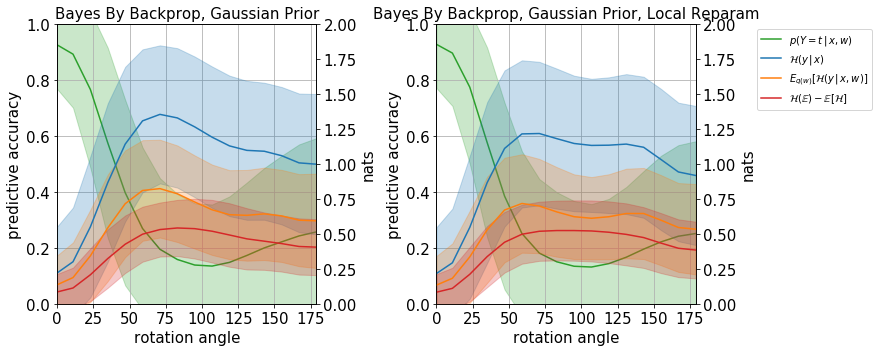

In [22]:
result_name_list = ['results_weight_uncertainty_MC_MNIST_gaussian', 'results_weight_uncertainty_local_reparam_MNIST']
names = ['Bayes By Backprop, Gaussian Prior' ,'Bayes By Backprop, Gaussian Prior, Local Reparam']

# plt.figure(dpi=120)

fs = 15
Ncols = len(result_name_list)

f, ax_vec = plt.subplots(1, Ncols, figsize=(6.5*Ncols, 5)) # , sharey=True


for idx, dirname in enumerate(result_name_list):
    
    ax = ax_vec[idx]
    ax2 = ax.twinx()

    correct_preds = np.load(dirname + '/correct_preds.npy')
    all_preds = np.load(dirname + '/all_preds.npy')
    all_sample_preds = np.load(dirname + '/all_sample_preds.npy')
    all_sample_preds = all_sample_preds + 1e-5

    # print(correct_preds.shape)
    # print(all_sample_preds.shape)

    # Get correct prediction probabilities
    correct_mean = correct_preds.mean(axis=0)
    correct_std = correct_preds.std(axis=0)

    # Compute the approx posterior predictive
    posterior_preds = all_sample_preds.mean(axis=1)
    total_entropy = -(posterior_preds * np.log(posterior_preds)).sum(axis=2)
    total_entropy_mean = total_entropy.mean(axis=0)
    total_entropy_std = total_entropy.std(axis=0)

    # Get sample wise metrics (entropy) -> aleatoric entropy
    sample_preds_entropy = -( all_sample_preds * np.log(all_sample_preds) ).sum(axis=3)
    aleatoric_entropy = sample_preds_entropy.mean(axis=1)
    aleatoric_entropy_mean = aleatoric_entropy.mean(axis=0)
    aleatoric_entropy_std = aleatoric_entropy.std(axis=0)

    # Get epistemic entropy 
    epistemic_entropy = total_entropy - aleatoric_entropy
    epistemic_entropy_mean = epistemic_entropy.mean(axis=0)
    epistemic_entropy_std = epistemic_entropy.std(axis=0)

    # print('expected entropy mean', aleatoric_entropy_mean.shape)
    # print('posterior entropy mean', posterior_mean_angle_entropy.shape)


    aa, = errorfill(rotations, correct_mean, yerr=correct_std, color=c[2], alpha_fill=0.25, ax=ax)

#     ax = plt.gca()
    ax.set_xlabel('rotation angle')
    ax.set_ylabel('predictive accuracy')
    ax.set_title('%s' % names[idx])
    ax.yaxis.grid() 
    ax.xaxis.grid() 

    
    ax2.set_ylabel('nats')
    bb, = errorfill(rotations, total_entropy_mean, yerr=total_entropy_std, color=c[0], ax=ax2, alpha_fill=0.25)
#     cc, = ax2.plot(rotations, aleatoric_entropy_mean, color=c[1])
#     dd, = ax2.plot(rotations, epistemic_entropy_mean, color=c[3])
    
    cc, = errorfill(rotations, aleatoric_entropy_mean, yerr=aleatoric_entropy_std, color=c[1], ax=ax2, alpha_fill=0.25)
    dd, = errorfill(rotations, epistemic_entropy_mean, yerr=epistemic_entropy_std, color=c[3], ax=ax2, alpha_fill=0.25)


    # lgd = plt.legend(['correct class', 'posterior predictive entropy'], loc='upper right',
    #                  prop={'size': 15, 'weight': 'normal'}, bbox_to_anchor=(1.4,1))


    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + [ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels() + ax2.get_xticklabels() + ax2.get_yticklabels()):
        item.set_fontsize(fs)
        item.set_weight('normal')

    plt.autoscale(enable=True, axis='x', tight=True)
    ax.set_ylim(bottom=0, top=1)
    ax2.set_ylim(bottom=0, top=2)

    
p_lgd = [aa, bb, cc, dd]
lgd = plt.legend(p_lgd, ['$p(Y = t\,|\,x, w)$', '$\mathcal{H}(y\,|\,x)$', '$E_{q(w)}[\mathcal{H}(y\,|\,x, w)]$', '$\mathcal{H}(\mathbb{E}) - \mathbb{E}[\mathcal{H}]$'], bbox_to_anchor=(1.7,1))

plt.tight_layout()



# Weight distribution plots

## Comparing priors and reparametrisations in bayes by backprop

(23928000,)
(23928000,)
(23928000,)
(23928000,)


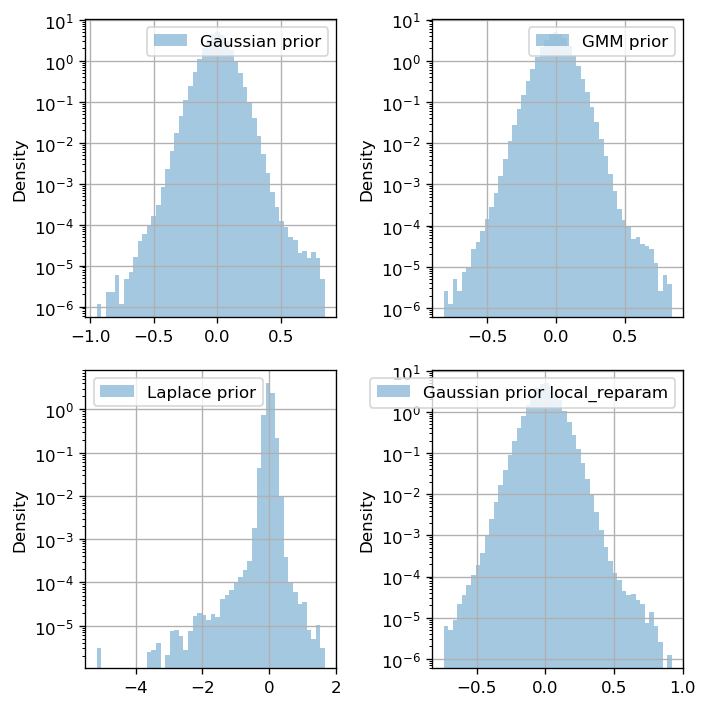

In [23]:
# result_name_list = ['results_regular_NN_MNIST', 'results_weight_uncertainty_MC_MNIST_gaussian', 'results_weight_uncertainty_MC_MNIST_GMM', 'results_weight_uncertainty_MC_MNIST_laplace', 'results_weight_uncertainty_local_reparam_MNIST', 'results_MC_dropout_MNIST', 'results_SGLD_MNIST', 'results_pSGLD_MNIST']

# names = ['Bayes By Backprop, Gaussian Prior' ,'Bayes By Backprop, Gaussian Prior, Local Reparam']

result_name_list = ['results_weight_uncertainty_MC_MNIST_gaussian', 'results_weight_uncertainty_MC_MNIST_GMM', 'results_weight_uncertainty_MC_MNIST_laplace', 'results_weight_uncertainty_local_reparam_MNIST']
names = ['Gaussian prior', 'GMM prior', 'Laplace prior', 'Gaussian prior local_reparam']

name_vec = ['Bayes_By_Backprop', 'Bayes_By_Backprop', 'Bayes_By_Backprop', 'Bayes_By_Backprop']

Nbins_vec = [50, 50, 50, 50]
fig = plt.figure(dpi=120, figsize=(3*len(result_name_list)/2, 3*len(result_name_list)/2))


for idx, dirname in enumerate(result_name_list):
    ax = fig.add_subplot(len(result_name_list)/2, len(result_name_list)/2, idx+1)
    weight_vector = np.load(dirname + '/weight_samples_' + name_vec[idx]  + '.npy')
    print(weight_vector.shape)
    
    Nbins = Nbins_vec[idx]

    symlim = 0.7
#     lim_idxs = np.where(np.logical_and(weight_vector>=symlim, weight_vector<=symlim))

    sns.distplot(weight_vector, Nbins, norm_hist=True, label=names[idx], ax=ax, kde=False)
#     ax.set_xlim((-symlim, symlim))
    ax.set_yscale('log')
    ax.set_ylabel('Density')
    ax.yaxis.grid() 
    ax.xaxis.grid()
    
    ax.legend()
# plt.title('Total parameters: %d' % (len(weight_vector)))


plt.tight_layout()

## Comparing approx inference methods

(2392800,)
(2392800,)
(23928000,)
(23928000,)


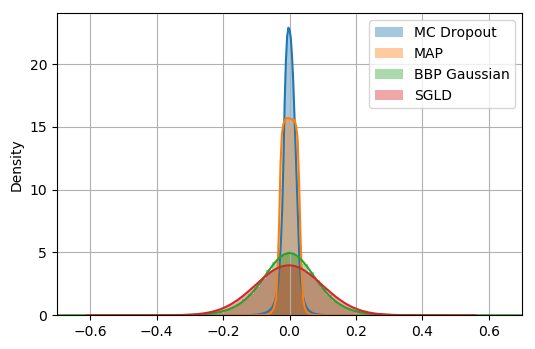

In [24]:
# result_name_list = ['results_regular_NN_MNIST', 'results_weight_uncertainty_MC_MNIST_gaussian', 'results_weight_uncertainty_MC_MNIST_GMM', 'results_weight_uncertainty_MC_MNIST_laplace', 'results_weight_uncertainty_local_reparam_MNIST', 'results_MC_dropout_MNIST', 'results_SGLD_MNIST', 'results_pSGLD_MNIST']

# names = ['Bayes By Backprop, Gaussian Prior' ,'Bayes By Backprop, Gaussian Prior, Local Reparam']

result_name_list = ['results_MC_dropout_MNIST', 'results_regular_NN_MNIST', 'results_weight_uncertainty_MC_MNIST_gaussian', 'results_SGLD_MNIST']
names = ['MC Dropout', 'MAP', 'BBP Gaussian', 'SGLD']

name_vec = ['MCDropout', 'Bayes_By_Backprop', 'Bayes_By_Backprop', 'SGLD']

Nbins_vec = [100, 100, 100, 100]
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)

for idx, dirname in enumerate(result_name_list):
    weight_vector = np.load(dirname + '/weight_samples_' + name_vec[idx]  + '.npy')
    print(weight_vector.shape)
    
    Nbins = Nbins_vec[idx]

    symlim = 0.7
    lim_idxs = np.where(np.logical_and(weight_vector>=symlim, weight_vector<=symlim))

    sns.distplot(weight_vector, Nbins, norm_hist=False, label=names[idx], ax=ax, color=c[idx])
    ax.set_xlim((-symlim, symlim))
    ax.set_ylabel('Density')
#     ax.set_yscale('log')
    
ax.legend()
ax.yaxis.grid() 
ax.xaxis.grid()
# plt.title('Total parameters: %d' % (len(weight_vector)))



### pSGLD vs SGLD plot in detail

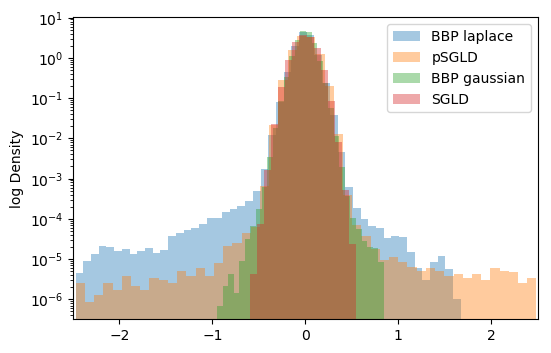

In [25]:


result_name_list = ['results_weight_uncertainty_MC_MNIST_laplace', 'results_pSGLD_MNIST', 'results_weight_uncertainty_MC_MNIST_gaussian', 'results_SGLD_MNIST']
names = ['BBP laplace', 'pSGLD', 'BBP gaussian', 'SGLD']

name_vec = ['Bayes_By_Backprop','SGLD', 'Bayes_By_Backprop', 'SGLD']

Nbins_vec = [50, 50, 30, 15]
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)

for idx, dirname in enumerate(result_name_list):
    weight_vector = np.load(dirname + '/weight_samples_' + name_vec[idx]  + '.npy')
    
#     weight_vector = np.random.choice(weight_vector, size=10000, replace=False, p=None)
#     print(weight_vector.shape)
    
    Nbins = Nbins_vec[idx]

    symlim = 2.5
    lim_idxs = np.where(np.logical_and(weight_vector<=symlim, weight_vector>=-symlim))

    sns.distplot(weight_vector[lim_idxs], Nbins, norm_hist=True, label=names[idx], ax=ax, kde=False, color=c[idx])
#     sns.kdeplot(np.log(weight_vector[lim_idxs]), shade=False, gridsize=100, cut=3, clip=None, legend=True, cumulative=False,
#                 shade_lowest=True, cbar=False, cbar_ax=None, cbar_kws=None, ax=ax, label=names[idx], color=c[idx])
    
#     ax.plot(test_x, log_density, label=names[idx], color=c[idx])

    ax.set_xlim((-symlim, symlim))
    ax.set_ylabel('log Density')
    ax.set_yscale('log')
    
ax.legend()



# Weight prunning plots

## SNR based

### SNR histogram

(23928000,)
(23928000,)
(23928000,)
(23928000,)


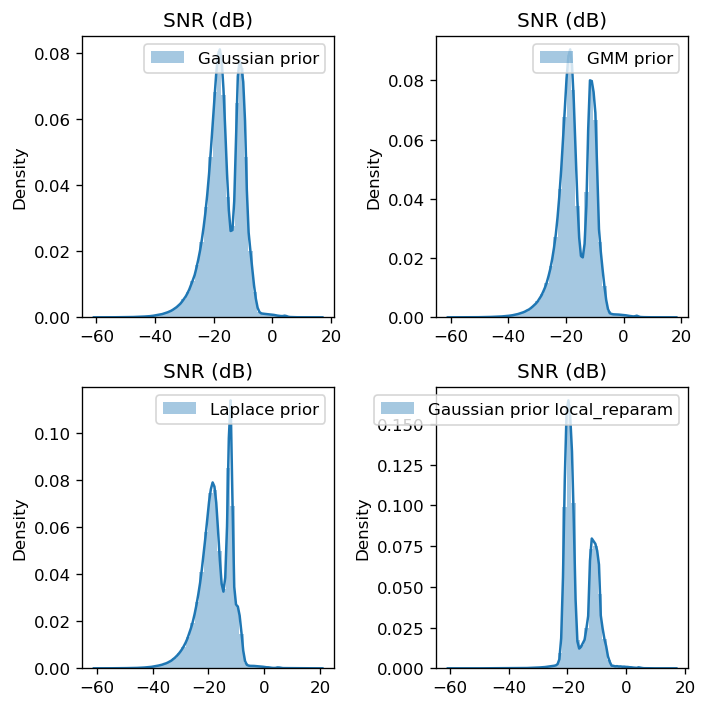

In [26]:
# result_name_list = ['results_regular_NN_MNIST', 'results_weight_uncertainty_MC_MNIST_gaussian', 'results_weight_uncertainty_MC_MNIST_GMM', 'results_weight_uncertainty_MC_MNIST_laplace', 'results_weight_uncertainty_local_reparam_MNIST', 'results_MC_dropout_MNIST', 'results_SGLD_MNIST', 'results_pSGLD_MNIST']

# names = ['Bayes By Backprop, Gaussian Prior' ,'Bayes By Backprop, Gaussian Prior, Local Reparam']

result_name_list = ['results_weight_uncertainty_MC_MNIST_gaussian', 'results_weight_uncertainty_MC_MNIST_GMM', 'results_weight_uncertainty_MC_MNIST_laplace', 'results_weight_uncertainty_local_reparam_MNIST']
names = ['Gaussian prior', 'GMM prior', 'Laplace prior', 'Gaussian prior local_reparam']

name_vec = ['Bayes_By_Backprop', 'Bayes_By_Backprop', 'Bayes_By_Backprop', 'Bayes_By_Backprop']

# Nbins_vec = [50, 50, 50, 50]
fig = plt.figure(dpi=120, figsize=(3*len(result_name_list)/2, 3*len(result_name_list)/2))


for idx, dirname in enumerate(result_name_list):
    ax = fig.add_subplot(len(result_name_list)/2, len(result_name_list)/2, idx+1)
    SNR_vector = np.load(dirname + '/snr_vector_' + name_vec[idx] + '.npy')
    print(weight_vector.shape)
    
    Nbins = Nbins_vec[idx]

    symlim = 0.7
#     lim_idxs = np.where(np.logical_and(weight_vector>=symlim, weight_vector<=symlim))
    
    SNR_vector = SNR_vector + 1e-6
    sns.distplot(10*np.log10(SNR_vector), norm_hist=False, label=names[idx], ax=ax)
#     ax.set_xlim((-symlim, symlim))
    ax.set_ylabel('Density')
    plt.title('SNR (dB)')
    
    ax.legend()
# plt.title('Total parameters: %d' % (len(weight_vector)))


plt.tight_layout()

In [27]:
print(min(SNR_vector))

1.052033e-06


### Results

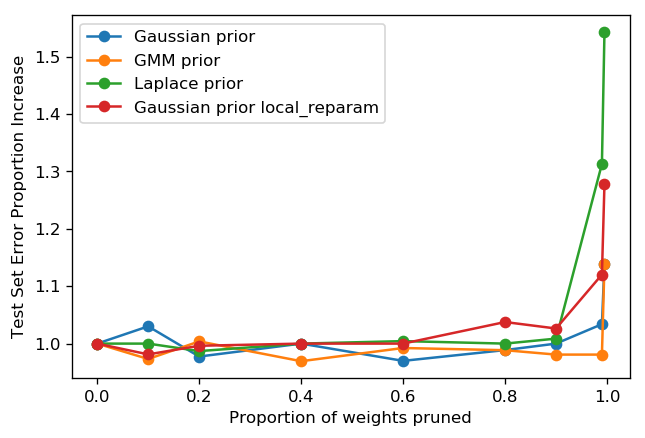

In [28]:
result_name_list = ['results_weight_uncertainty_MC_MNIST_gaussian', 'results_weight_uncertainty_MC_MNIST_GMM', 'results_weight_uncertainty_MC_MNIST_laplace', 'results_weight_uncertainty_local_reparam_MNIST']

names = ['Gaussian prior', 'GMM prior', 'Laplace prior', 'Gaussian prior local_reparam']

name_vec = ['Bayes_By_Backprop', 'Bayes_By_Backprop', 'Bayes_By_Backprop', 'Bayes_By_Backprop']


fig = plt.figure(dpi=120)
ax = fig.add_subplot(111)

for idx, dirname in enumerate(result_name_list):
    
#     ax = fig.add_subplot(2, len(result_name_list), idx+1)
    
#     snr_vector = np.load(dirname + '/snr_vector_' + name_vec[idx] + '.npy') 
    prune_err = np.load(dirname + '/snr_prune_err.npy')
    snr_proportions = np.load(dirname + '/snr_proportions.npy')
    
    ax.plot(snr_proportions, prune_err/prune_err[0], '-o', label=names[idx])
    
    

    ax.set_ylabel('Test Set Error Proportion Increase')
    ax.set_xlabel('Proportion of weights pruned')
#     ax.set_yscale('log')
#     ax.set_xscale('log')
    
ax.legend()




## KLD based

Something kind of strange goes on here: Some KL divergences that are estimated seem to come out negative, which shouldnt happen. This is due to variance when the KL divergence is estimated with MC. We use 30 MC samples. They are the delta at ~-20 = log(eps). Pruning them improves network performance.

**This could mean there is an issue with how the likelihood is calculated under the GMM prior as samples are more likely to be from the prior than from q**
Also, There is a delta just under 0 for all models, which makes this a little bit suspicious

Surprisingly this doesnt cause a loss in performance but does allow for better parameter pruning

### KLD density

(23928000,)
(23928000,)
(23928000,)
(23928000,)


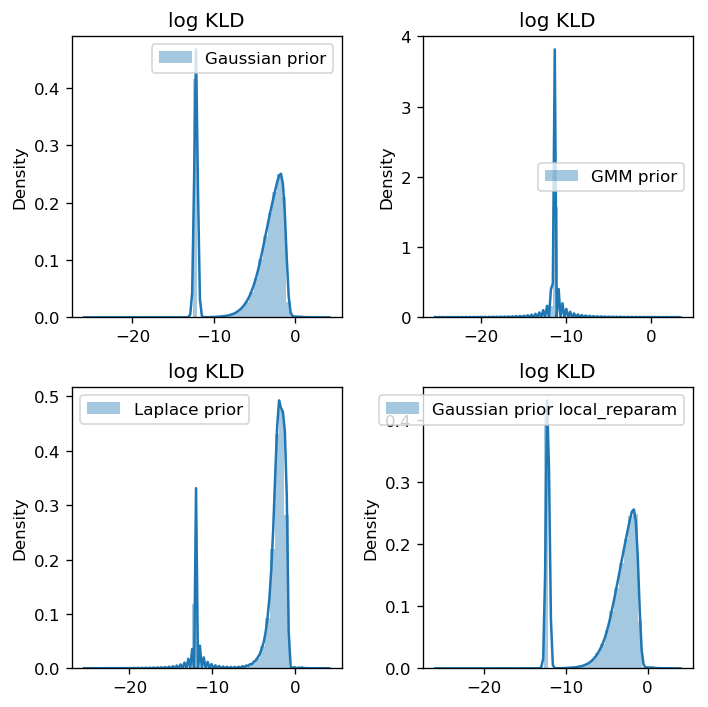

In [29]:
# result_name_list = ['results_regular_NN_MNIST', 'results_weight_uncertainty_MC_MNIST_gaussian', 'results_weight_uncertainty_MC_MNIST_GMM', 'results_weight_uncertainty_MC_MNIST_laplace', 'results_weight_uncertainty_local_reparam_MNIST', 'results_MC_dropout_MNIST', 'results_SGLD_MNIST', 'results_pSGLD_MNIST']

# names = ['Bayes By Backprop, Gaussian Prior' ,'Bayes By Backprop, Gaussian Prior, Local Reparam']

result_name_list = ['results_weight_uncertainty_MC_MNIST_gaussian', 'results_weight_uncertainty_MC_MNIST_GMM', 'results_weight_uncertainty_MC_MNIST_laplace', 'results_weight_uncertainty_local_reparam_MNIST']
names = ['Gaussian prior', 'GMM prior', 'Laplace prior', 'Gaussian prior local_reparam']

name_vec = ['Bayes_By_Backprop', 'Bayes_By_Backprop', 'Bayes_By_Backprop', 'Bayes_By_Backprop']

# Nbins_vec = [50, 50, 50, 50]
fig = plt.figure(dpi=120, figsize=(3*len(result_name_list)/2, 3*len(result_name_list)/2))


for idx, dirname in enumerate(result_name_list):
    ax = fig.add_subplot(len(result_name_list)/2, len(result_name_list)/2, idx+1)
    KLD_vector = np.load(dirname + '/kld_vector_' + name_vec[idx] + '.npy')
    print(weight_vector.shape)
    
    Nbins = Nbins_vec[idx]

    symlim = 0.7
#     lim_idxs = np.where(np.logical_and(weight_vector>=symlim, weight_vector<=symlim))
    neg_idxs = KLD_vector<=0

    KLD_vector[neg_idxs] += np.max(np.abs(KLD_vector[KLD_vector<=0])) + 1e-6
    KLD_vector[neg_idxs] *= 1e-5
    
#     KLD_vector = KLD_vector[KLD_vector>0]
    sns.distplot(np.log(KLD_vector), norm_hist=False, label=names[idx], ax=ax)
#     ax.set_xlim((-symlim, symlim))
    ax.set_ylabel('Density')
    plt.title('log KLD')
    
    ax.legend()
# plt.title('Total parameters: %d' % (len(weight_vector)))


plt.tight_layout()

In [30]:
KLD_vector[KLD_vector<=0] + np.max(np.abs(KLD_vector[KLD_vector<=0])) + 1e-8

ValueError: zero-size array to reduction operation maximum which has no identity

### Results

In [ ]:
result_name_list = ['results_weight_uncertainty_MC_MNIST_gaussian', 'results_weight_uncertainty_MC_MNIST_GMM', 'results_weight_uncertainty_MC_MNIST_laplace', 'results_weight_uncertainty_local_reparam_MNIST']

names = ['Gaussian prior', 'GMM prior', 'Laplace prior', 'Gaussian prior local_reparam']

name_vec = ['Bayes_By_Backprop', 'Bayes_By_Backprop', 'Bayes_By_Backprop', 'Bayes_By_Backprop']


fig = plt.figure(dpi=120)
ax = fig.add_subplot(111)

for idx, dirname in enumerate(result_name_list):
    
#     ax = fig.add_subplot(2, len(result_name_list), idx+1)
    
#     snr_vector = np.load(dirname + '/snr_vector_' + name_vec[idx] + '.npy') 
    prune_err = np.load(dirname + '/kld_prune_err.npy')
    kld_proportions = np.load(dirname + '/kld_proportions.npy')
    
    ax.plot(snr_proportions, prune_err/prune_err[0], '-o', label=names[idx])
    
    

    ax.set_ylabel('Test Set Error Proportion Increase')
    ax.set_xlabel('Proportion of weights pruned')
#     ax.set_yscale('log')
#     ax.set_xscale('log')
    
ax.legend()





In [ ]:
all_preds = np.load('results_regular_NN_MNIST' + '/all_preds.npy')

all_preds = all_preds[:, 0, :]
pred_class = np.argmax(all_preds, axis=1)
correct_vec = (pred_class == targets).astype(int)

bin_step = 0.1
bins = np.arange(0, 1+bin_step, bin_step)


bin_idxs = np.digitize(np.amax(all_preds, axis=1), bins)

bins_centres = bins[1:] - bin_step/2
bin_counts = np.ones(len(bins_centres))
bin_corrects = np.zeros(len(bins_centres))


for nbin in range(len(bins_centres)):
    print(nbin)
    bin_counts[nbin] = np.sum((bin_idxs==nbin).astype(int))
    bin_corrects[nbin] = np.sum(correct_vec[bin_idxs==nbin])
    
bin_corrects[len(bins_centres)-1] += 
    
print(bin_counts)
print(bin_corrects)

print(correct_vec.shape)
plt.hist(bin_idxs)

# Calibration plots

We use the data from the rotation experiments because it contains predictions for the whole test set when rotation = 0. 

In [19]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])



[7 2 1 ... 4 5 6]


Text(0.5,1,'Calibration Curve')

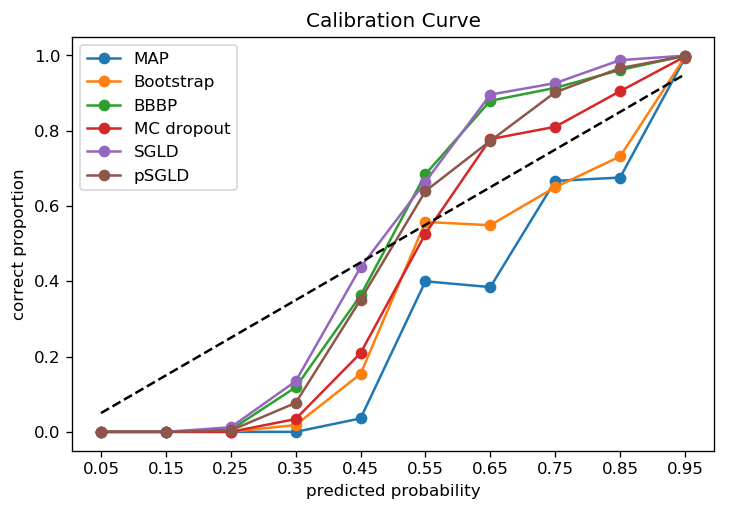

In [26]:
result_name_list = ['results_regular_NN_MNIST', 'results_bootstrap_ensemble_NN_MNIST', 'results_weight_uncertainty_MC_MNIST_gaussian', 'results_MC_dropout_MNIST', 'results_SGLD_MNIST', 'results_pSGLD_MNIST']
names = ['MAP', 'Bootstrap', 'BBBP', 'MC dropout', 'SGLD', 'pSGLD']


bin_step = 0.1
bins = np.arange(0, 1.0001, bin_step)


fig = plt.figure(dpi=120)
ax = fig.add_subplot(111)

min_idx = 10

for dir_idx, dirname in enumerate(result_name_list):
    

    targets = np.load('MNIST_test_targets.npy')
    all_preds = np.load(dirname + '/all_preds.npy')


    all_preds = all_preds[:, 0, :]
    pred_class = np.argmax(all_preds, axis=1)

    expanded_preds = np.reshape(all_preds, -1)
    pred_class_OH_expand = np.reshape(get_one_hot(pred_class, 10), -1)
    targets_class_OH_expand = np.reshape(get_one_hot(targets, 10), -1)
    
    correct_vec = (targets_class_OH_expand*(pred_class_OH_expand == targets_class_OH_expand)).astype(int)
#     correct_vec = (pred_class == targets).astype(int)

    bin_idxs = np.digitize(expanded_preds, bins, right=True)
    bin_idxs = bin_idxs - 1

    bin_centers = bins[1:] - bin_step/2

    bin_counts = np.ones(len(bin_centers))
    bin_corrects = np.zeros(len(bin_centers))
    
#     print(min(bin_idxs))
    if min(bin_idxs) < min_idx:
        min_idx = min(bin_idxs)

    for nbin in range(len(bin_centers)):

        bin_counts[nbin] = np.sum((bin_idxs==nbin).astype(int))
        bin_corrects[nbin] = np.sum(correct_vec[bin_idxs==nbin])

    have_data = bin_counts > 0  
    bin_pcorr = bin_corrects[have_data] / bin_counts[have_data]
    
#     print(names[dir_idx])
#     print(bin_counts) 
#     print(bin_corrects)
    


    ax.plot(bin_centers[have_data], bin_pcorr, '-o', label=names[dir_idx])


# print(min_idx)

ax.legend()
plt.tight_layout()

ax.plot(bin_centers[min_idx:], bin_centers[min_idx:], '--', c='k')
ax.set_xticks(bin_centers[min_idx:]) # [labels]

ax.set_xlabel('predicted probability')
ax.set_ylabel('correct proportion')
ax.set_title('Calibration Curve')


